In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


TensorFlow is already loaded. Please restart the runtime to change versions.
(4604, 30, 1)
(1535, 30, 1)
(1535, 30, 1)
(4604, 1)
(1535, 1)
(1535, 1)
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 30, 1)             0         
_________________________________________________________________
dense_121 (Dense)            (None, 30, 32)            64        
_________________________________________________________________
leaky_re_lu_73 (LeakyReLU)   (None, 30, 32)            0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_122 (Dense)            (None, 30, 64)            2112      
_________________________________________________________________
leaky_re_lu_74 (LeakyReLU)   (None, 30, 6

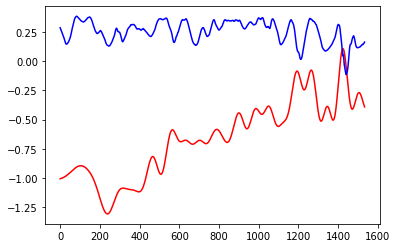

In [101]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
from sklearn.preprocessing import StandardScaler
%tensorflow_version 1.x
%matplotlib inline


def min_max_scaler(x):
    scaled_x = (x - x.min()) / (x.max() - x.min())
    return scaled_x


def max_abs_scaler(x):
    scaled_x = x / abs(x).max()
    return scaled_x


# input_data_length = int(input('input_data_length : '))
input_data_length = 30
model_num = 104
# num_classes = 3

gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/'

#           read reg ohlcv          #
file_path = gdrive_path + 'ohlcv_reg/'
file_list = os.listdir(file_path)
# print(file_list)
# breakpoint
# file = '2020-04-02 BackTest POWR.xlsx' 
file = '2020-04-02 BackTest GNT_from_excel.xlsx'
ohlcv_reg = pd.read_excel(file_path + file, index_col=0)
# print(ohlcv_reg.iloc[:, [-7]])
# breakpoint

#     X_data : idl 만큼의 close? (일단),    Y_data : reg
#     실시간으로 reg의 형태가 machine learning으로는 고정되지 않기 때문에,
#     먼저 고정을 시키고, deep learning을 이용해 실시간으로 고정된 regression 결과를 뽑아낼 수 있는지 확인한다.
#     충분히 가능성 있다.     #

#         reg_target = close인 경우 앞의 데이터가 산다.       #  close/ close_reg
ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.MACD_Signal.isna()):, :]
reg_target = ohlcv_reg[:, [-7]].astype(np.float32)
reg_result = ohlcv_reg[:, [-5]].astype(np.float32)
# print(np.sum(np.isnan(reg_target), axis=0))
# breakpoint

scaler_x = StandardScaler()
scaler_y = StandardScaler()
reg_target = scaler_x.fit_transform(reg_target)
reg_result = scaler_y.fit_transform(reg_result)
# reg_target = min_max_scaler(reg_target)
# reg_result = max_abs_scaler(reg_result)
# print(reg_target, reg_result)
# breakpoint

dataX, dataY = list(), list()
for i in range(input_data_length, len(reg_target)):

  group_x = reg_target[i + 1 - input_data_length: i + 1]
  group_y = reg_result[i]
  # print(group_x[0])
  # quit()

  #   데이터 값에 결측치가 존재하는 경우 #
  if sum(sum(np.isnan(group_x))) > 0:
      continue

  dataX.append(group_x)  # dataX 리스트에 추가
  dataY.append(group_y)

Made_X = np.array(dataX)
Made_Y = np.array(dataY)
# print(Made_X.shape, Made_Y.shape)
# breakpoint


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Made_X, Made_Y, test_size=0.4,
                                                   shuffle=False)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5,
                                                   shuffle=False)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)
# breakpoint

row = X_train.shape[1]
col = X_train.shape[2]

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.layers import Dense, LSTM, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix

def FER_Model(input_shape=(row, col)):

    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Dense(32)(visible)
    # net = layers.LSTM(64, return_sequences=True)(visible)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dropout(0.3)(net)
    
    net = layers.Dense(64)(net)
    # net = layers.LSTM(64, return_sequences=True)(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    # net = layers.LSTM(64, return_sequences=False)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Flatten()(net)
    net = layers.Dense(1)(net)
    # create model 
    model = Model(inputs =visible, outputs = net)
    # summary layers
    model.summary()

# # model.add(LSTM(50, return_sequences= True, activation='relu', input_shape=(row, col)))
# # model.add(LSTM(50, return_sequences=True, activation='relu'))
# # model.add(LSTM(50))
# model.add(Dense(1))
    
    return model

model = FER_Model()
# from keras.models import load_model
# model = load_model(gdrive_path + 'model/rapid_ascending %s_%s_ohlc.hdf5' % (input_data_length, model_num))

opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
  
    
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath = gdrive_path + "model/rapid_ascending %s_%s_ohlc.hdf5" % (input_data_length, model_num)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=30)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 100
history = model.fit(X_train, Y_train,
                    epochs=num_epochs,
                    batch_size=32,
                    validation_data=(X_val, Y_val),
                    verbose=2,
                    callbacks=callbacks_list,
                    shuffle=False,
                    )

#         RESULT COMPARING    #
pred_reg = model.predict(X_test)

plt.plot(Y_test, color='r', label='Y_test')
plt.plot(pred_reg, color='b',  label='pred_reg')
plt.show()


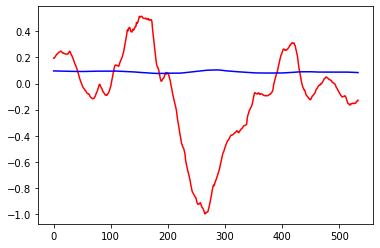

In [100]:
file_list = os.listdir(file_path)
# print(file_list)
# breakpoint
file = file_list[0]
ohlcv_reg = pd.read_excel(file_path + file, index_col=0)
# print(ohlcv_reg.iloc[:, [1, -5]])
# breakpoint

#     X_data : idl 만큼의 close? (일단),    Y_data : reg
#     실시간으로 reg의 형태가 machine learning으로는 고정되지 않기 때문에,
#     먼저 고정을 시키고, deep learning을 이용해 실시간으로 고정된 regression 결과를 뽑아낼 수 있는지 확인한다.
#     충분히 가능성 있다.     #

#         reg_target = close인 경우 앞의 데이터가 산다.       #  close/ close_reg
ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.MACD_Signal.isna()):, :]
reg_target = ohlcv_reg[:, [-7]].astype(np.float32)
reg_result = ohlcv_reg[:, [-5]].astype(np.float32)
# ohlcv_data = ohlcv_reg.values[sum(ohlcv_reg.MACD_Signal.isna()):, :-4].astype(np.float)
# print(np.sum(np.isnan(ohlcv_data), axis=0))
# breakpoint

scaler_x = StandardScaler()
scaler_y = StandardScaler()
reg_target = scaler_x.fit_transform(reg_target)
reg_result = scaler_y.fit_transform(reg_result)
# reg_target = min_max_scaler(reg_target)
# reg_result = max_abs_scaler(reg_result)
# print(reg_target, reg_result)
# breakpoint

dataX, dataY = list(), list()
for i in range(input_data_length, len(reg_target)):

  group_x = reg_target[i + 1 - input_data_length: i + 1]
  group_y = reg_result[i]
  # print(group_x[0])
  # quit()

  #   데이터 값에 결측치가 존재하는 경우 #
  if sum(sum(np.isnan(group_x))) > 0:
      continue

  dataX.append(group_x)  # dataX 리스트에 추가
  dataY.append(group_y)

Made_X = np.array(dataX)
Made_Y = np.array(dataY)

pred_reg = model.predict(Made_X)

plt.plot(Made_Y, color='r', label='Y_test')
plt.plot(pred_reg, color='b',  label='pred_reg')
plt.show()